In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<function matplotlib.pyplot.show(close=None, block=None)>

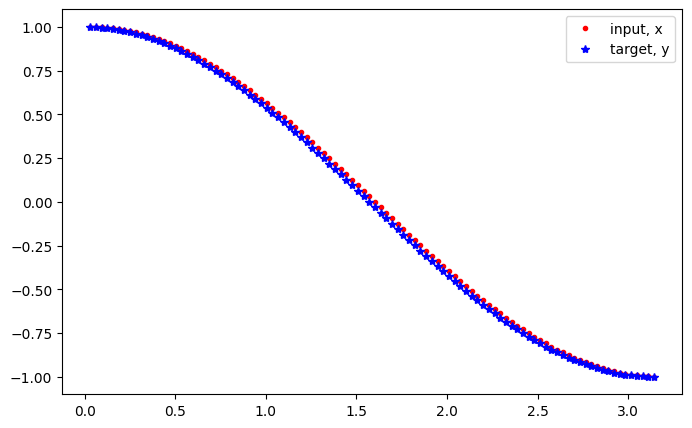

In [2]:
plt.figure(figsize=(8, 5))

seq_length = 100

time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.cos(time_steps)
data.resize((seq_length+1, 1))

x = data[:-1]
y = data[1:]

plt.plot(time_steps[1:], x, 'r.', label='input, x')
plt.plot(time_steps[1:], y, 'b*', label='target, y')

plt.legend(loc='best')
plt.show

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        batch_size = x.size(0)

        r_out, hidden = self.rnn(x, hidden)

        r_out = r_out.view(-1, self.hidden_dim)

        output = self.fc(r_out)

        return output, hidden

In [4]:
input_size = 1
output_size = 1
hidden_dim = 32
n_layers = 2

rnn = RNN(input_size, output_size, hidden_dim, n_layers)
rnn

RNN(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

In [6]:
def train(rnn, n_steps, print_every):

    hidden = None

    for batch_i, step in enumerate(range(n_steps)):

        time_steps = np.linspace(step * np.pi, (step + 1) * np.pi, seq_length + 1)

        data = np.cos(time_steps)
        data.resize((seq_length + 1, 1))

        x = data[:-1]
        y = data[1:]

        x_tensor = torch.Tensor(x).unsqueeze(0)
        y_tensor = torch.Tensor(y)

        prediction, hidden = rnn(x_tensor, hidden)

        hidden = hidden.data

        loss = criterion(prediction, y_tensor)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch_i % print_every == 0:
            print("Loss:", loss.item())

            plt.plot(time_steps[1:], x, 'r.')

            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b*')
            plt.show()
    return rnn

Loss: 0.46802955865859985


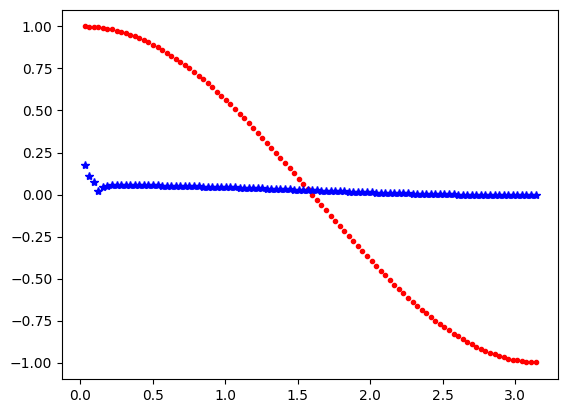

Loss: 0.03221040591597557


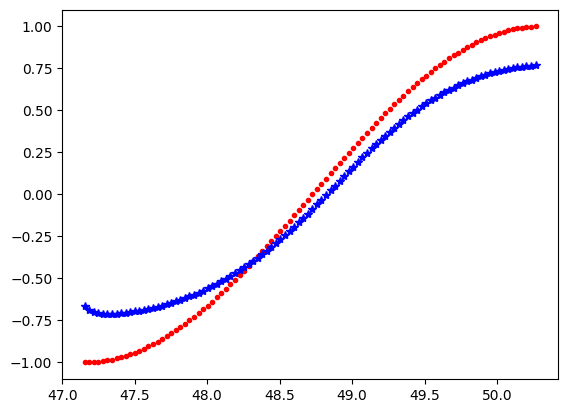

Loss: 0.01029093936085701


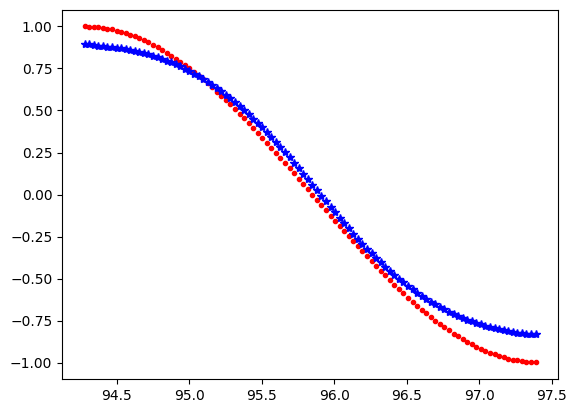

Loss: 0.00745251402258873


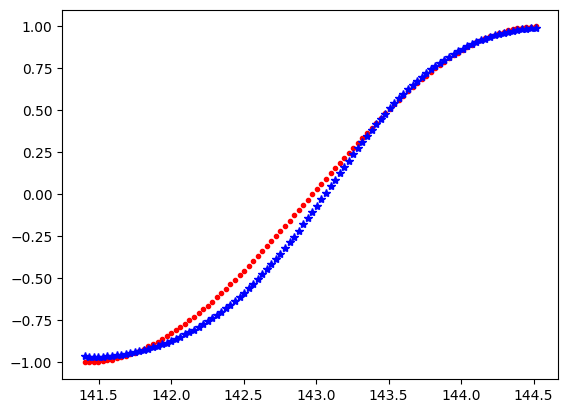

Loss: 0.004232494160532951


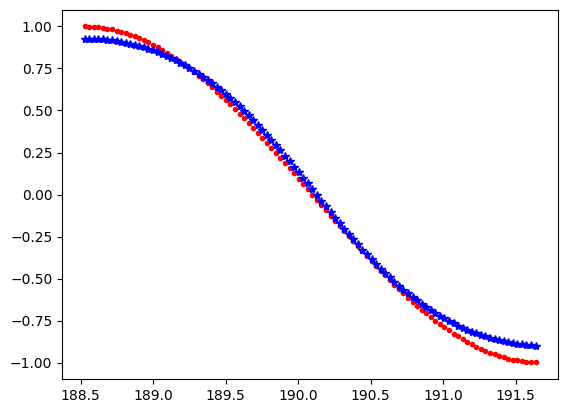

Loss: 0.0031958201434463263


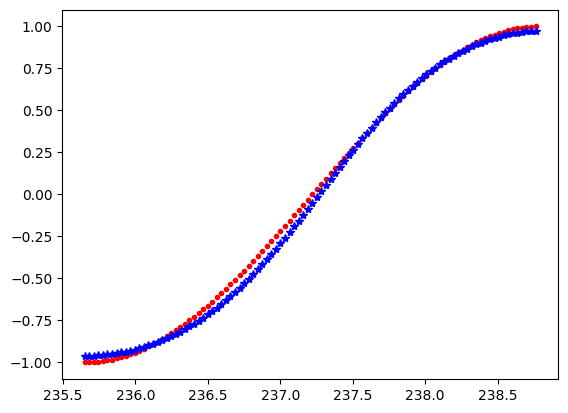

Loss: 0.0019307066686451435


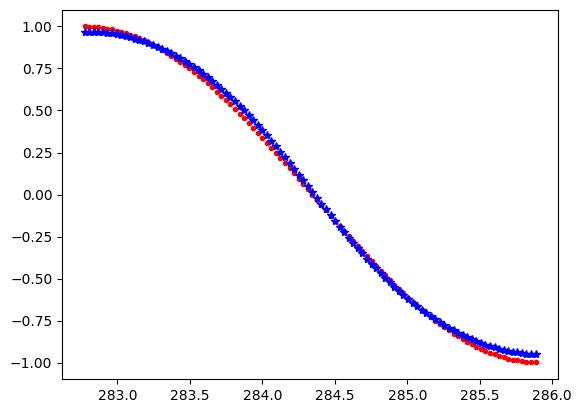

Loss: 0.0014572086511179805


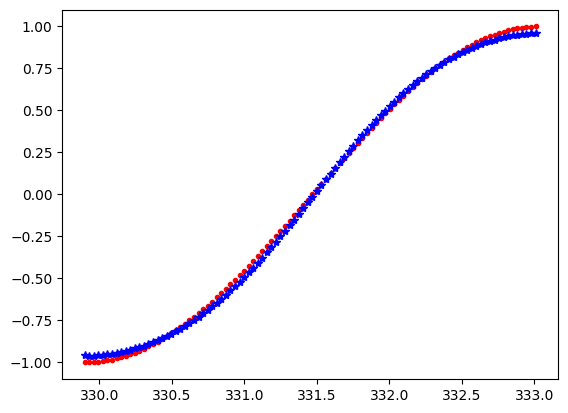

Loss: 0.0007462906651198864


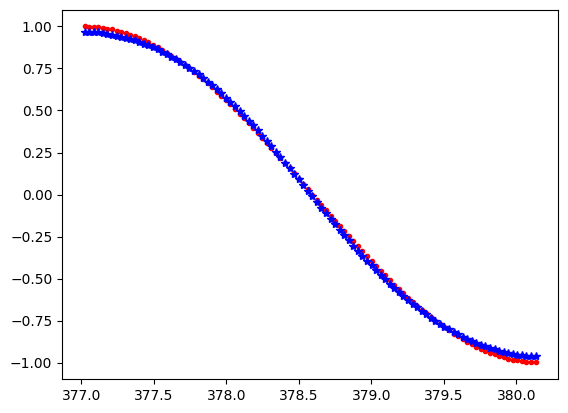

Loss: 0.000594654877204448


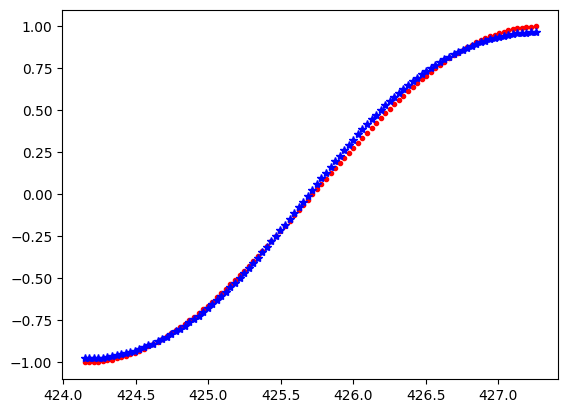

In [7]:
n_steps = 150
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)

In [15]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [16]:
N = 10

x_data = []
y_data = []

for i in range(len(data) - N):
    x_data.append(data[i:i+N].flatten())
    y_data.append(data[i+N])

x_data = np.array(x_data)
y_data = np.array(y_data)

x_tensor = torch.Tensor(x_data)
y_tensor = torch.Tensor(y_data)


In [17]:
input_size = N
hidden_size = 32
output_size = 1

ffn = FeedforwardNN(input_size, hidden_size, output_size)
criterion_ffn = nn.MSELoss()
optimizer_ffn = torch.optim.Adam(ffn.parameters(), lr=0.001)

In [18]:
n_epochs = 200
batch_size = 16

for epoch in range(n_epochs):
    permutation = torch.randperm(x_tensor.size(0))
    epoch_loss = 0

    for i in range(0, x_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = x_tensor[indices], y_tensor[indices]

        optimizer_ffn.zero_grad()
        outputs = ffn(batch_x)  # batch_x: (batch_size, N)
        loss = criterion_ffn(outputs, batch_y)
        loss.backward()
        optimizer_ffn.step()

        epoch_loss += loss.item()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss / len(x_tensor):.6f}")

Epoch 20/200, Loss: 0.000040
Epoch 40/200, Loss: 0.000021
Epoch 60/200, Loss: 0.000012
Epoch 80/200, Loss: 0.000009
Epoch 100/200, Loss: 0.000008
Epoch 120/200, Loss: 0.000006
Epoch 140/200, Loss: 0.000006
Epoch 160/200, Loss: 0.000005
Epoch 180/200, Loss: 0.000004
Epoch 200/200, Loss: 0.000004


In [19]:
rnn.eval()
ffn.eval()

FeedforwardNN(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [20]:
test_steps = np.linspace(10 * np.pi, 11 * np.pi, seq_length + 1)
test_data = np.cos(test_steps)

In [21]:
x_test = []
y_test = []

for i in range(len(test_data) - N):
    x_test.append(test_data[i:i+N])
    y_test.append(test_data[i+N])

x_test = np.array(x_test)
y_test = np.array(y_test)

x_test_tensor = torch.Tensor(x_test)
y_test_tensor = torch.Tensor(y_test).unsqueeze(1)

In [22]:
rnn_hidden = None
rnn_pred = []
for i in range(len(x_test)):
    x_input = torch.Tensor(test_data[i:i+1]).unsqueeze(0).unsqueeze(2)
    rnn_out, rnn_hidden = rnn(x_input, rnn_hidden)
    rnn_pred.append(rnn_out.data.numpy().flatten())

rnn_pred = np.array(rnn_pred).flatten()

ffn_pred = ffn(x_test_tensor).detach().numpy().flatten()

In [23]:
rnn_mse = criterion(torch.Tensor(rnn_pred), y_test_tensor).item()
ffn_mse = criterion(torch.Tensor(ffn_pred), y_test_tensor).item()

print(f"RNN MSE: {rnn_mse:.6f}")
print(f"Feedforward NN MSE: {ffn_mse:.6f}")

RNN MSE: 0.927106
Feedforward NN MSE: 0.884339


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([91, 1])) that is different to the input size (torch.Size([91])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


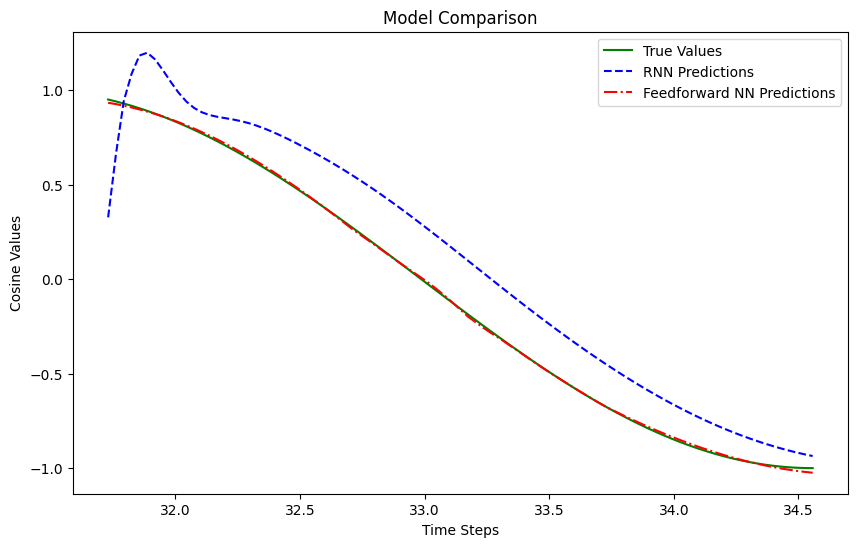

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(test_steps[N:], y_test, 'g-', label='True Values')
plt.plot(test_steps[N:], rnn_pred, 'b--', label='RNN Predictions')
plt.plot(test_steps[N:], ffn_pred, 'r-.', label='Feedforward NN Predictions')
plt.legend(loc='best')
plt.xlabel('Time Steps')
plt.ylabel('Cosine Values')
plt.title('Model Comparison')
plt.show()